In [1034]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [1035]:
all_data = pd.read_csv("./OFZ Data - Dataset.csv")
data = all_data[["years_to_maturity", "Rate", "Inflation", "moex_ytm"]]
data = data.apply(pd.to_numeric)

In [1195]:
sample = data[data["Rate"] >10]
#sample = data[(data["Rate"]<=8) & (data["Rate"] > 7.5)]
sample["lnt"] = np.log(sample["years_to_maturity"])
sample["et"] = np.exp(-0.5 *sample["years_to_maturity"])
sample["lnR"] = np.exp(sample["Rate"])
print(sample.shape)

(179, 7)


C:\Users\igor\AppData\Local\Temp\ipykernel_13056\1966550749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["lnt"] = np.log(sample["years_to_maturity"])
C:\Users\igor\AppData\Local\Temp\ipykernel_13056\1966550749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["et"] = np.exp(-0.5 *sample["years_to_maturity"])
C:\Users\igor\AppData\Local\Temp\ipykernel_13056\1966550749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

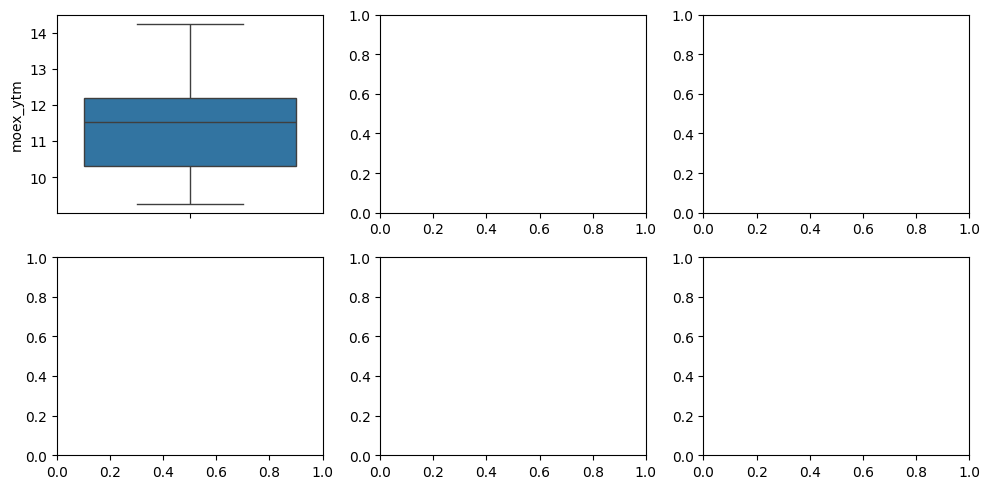

In [1196]:
fig, axs = plt.subplots(2,3, figsize = (10,5))
plt1 = sns.boxplot(sample['moex_ytm'], ax = axs[0,0])

plt.tight_layout()

In [1197]:
"""
plt.boxplot(sample.moex_ytm)
Q1 = sample.moex_ytm.quantile(0.25)
Q3 = sample.moex_ytm.quantile(0.75)
IQR = Q3 - Q1
sample = sample[(sample.moex_ytm >= Q1 - IQR) & (sample.moex_ytm <= Q3 + IQR)]
"""

'\nplt.boxplot(sample.moex_ytm)\nQ1 = sample.moex_ytm.quantile(0.25)\nQ3 = sample.moex_ytm.quantile(0.75)\nIQR = Q3 - Q1\nsample = sample[(sample.moex_ytm >= Q1 - IQR) & (sample.moex_ytm <= Q3 + IQR)]\n'

In [1198]:
#sns.pairplot(sample)

In [1199]:
np.random.seed(0)
df_train, df_test = train_test_split(sample, train_size = 0.7, test_size = 0.3, random_state = 100)
y_train = df_train.pop('moex_ytm')
X_train = df_train

In [1214]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
lm = ElasticNet(0.1)
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=4)             # running RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('years_to_maturity', True, 1),
 ('Rate', True, 1),
 ('Inflation', True, 1),
 ('lnt', True, 1),
 ('et', False, 3),
 ('lnR', False, 2)]

In [1215]:
import statsmodels.api as sm  
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_rfe).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               moex_ytm   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     133.7
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           3.05e-43
Time:                        17:22:24   Log-Likelihood:                -81.692
No. Observations:                 125   AIC:                             173.4
Df Residuals:                     120   BIC:                             187.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 9.5052      0.22

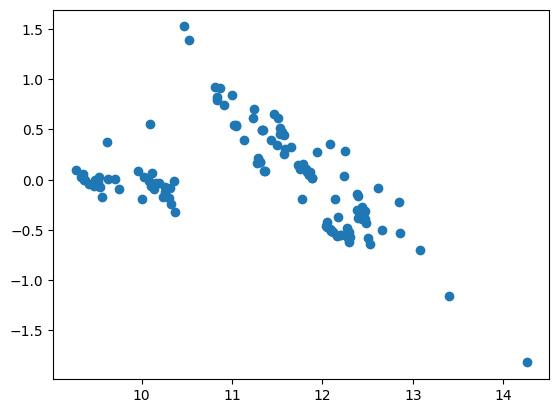

In [1216]:
y_train_price = lm.predict(X_train_rfe)
res = (y_train_price - y_train)
plt.scatter(y_train,res)
plt.show()

In [1217]:
y_test = df_test['moex_ytm']
X_test = df_test
X_test = sm.add_constant(X_test, has_constant='add')

In [1218]:
X_test_rfe = X_test[X_train_rfe.columns]
y_pred = lm.predict(X_test_rfe)

In [1219]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_absolute_percentage_error
r2_score(y_test, y_pred)

0.8872294020852214

In [1220]:
mean_absolute_percentage_error(y_test, y_pred)

0.02157782012892194